In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)


2.0.0


In [2]:
import numpy as np
import pandas as pd
import csv
import pickle

import tensorflow as tf
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, Bidirectional, concatenate, SpatialDropout1D, Dropout, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam

In [3]:
train_df = pd.read_csv("Data/dataset_train.csv",sep='\t', index_col='index')
test_df = pd.read_csv("Data/dataset_test_no_labels.csv",sep='\t',index_col='index')
labels = train_df['label']

In [4]:
max_sequence_length = 300
max_vocabulary_size=1000
nb_examples = len(labels)
train_size = int(0.8 * nb_examples)

In [5]:
vocabulary_size = max_vocabulary_size
BATCH_SIZE = 1024
embedding_size = 64
hidden_size = 64
epochs = 10

In [6]:
import pickle

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [8]:
sentence_1_tok = tokenizer.texts_to_sequences(train_df["sentence_1"])
sentence_2_tok = tokenizer.texts_to_sequences(train_df["sentence_2"])

In [9]:
sentence_1_pad = sequence.pad_sequences(sentence_1_tok,maxlen=max_sequence_length, dtype='int32', truncating="post",padding="post")
sentence_2_pad = sequence.pad_sequences(sentence_2_tok,maxlen=max_sequence_length, dtype='int32', truncating="post",padding="post")

In [10]:
def translate_labels(labels,inverse=False):
    convert_dict = {
      'entailment': 0,
      'neutral': 1,
      'contradiction': 2
    }
    convert_dict_inverse = {
      0: 'entailment',
      1: 'neutral',
      2: 'contradiction'
    }
    new_labels=[]
    if inverse:
        new_labels.append(convert_dict_inverse[labels])
    else:
        for label in labels:
            new_labels.append(convert_dict[label])
    
    return new_labels

In [11]:
def input_fn(input_1,input_2, labels, BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(({"Premise": input_1, "Hypothesis": input_2}, labels))
    #dataset = dataset.shuffle(1000).batch(BATCH_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [13]:
num_labels = translate_labels(labels)
dataset = input_fn(sentence_1_pad,sentence_2_pad, num_labels, BATCH_SIZE)
dataset

<BatchDataset shapes: ({Premise: (None, 300), Hypothesis: (None, 300)}, (None,)), types: ({Premise: tf.int32, Hypothesis: tf.int32}, tf.int32)>

In [ ]:
train_dataset = dataset.take(train_size) 
val_dataset = dataset.skip(train_size)

In [14]:
premise = tf.keras.Input(shape=(max_sequence_length), name='Premise')        # Sequence of ints
hypothesis = tf.keras.Input(shape=(max_sequence_length), name='Hypothesis')  # Sequence of ints

emb_1 = Embedding(vocabulary_size,embedding_size)(premise)       
emb_2 = Embedding(vocabulary_size,embedding_size)(hypothesis)

x = concatenate([emb_1, emb_2], axis = -2)
x = Bidirectional(tf.keras.layers.LSTM(hidden_size))(x)
x = Dense(hidden_size, activation='relu')(x)
x = Dense(3, activation='softmax')(x)

model = Model(inputs=[premise, hypothesis], outputs=x)
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Premise (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
Hypothesis (InputLayer)         [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 64)      64000       Premise[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 64)      64000       Hypothesis[0][0]                 
______________________________________________________________________________________________

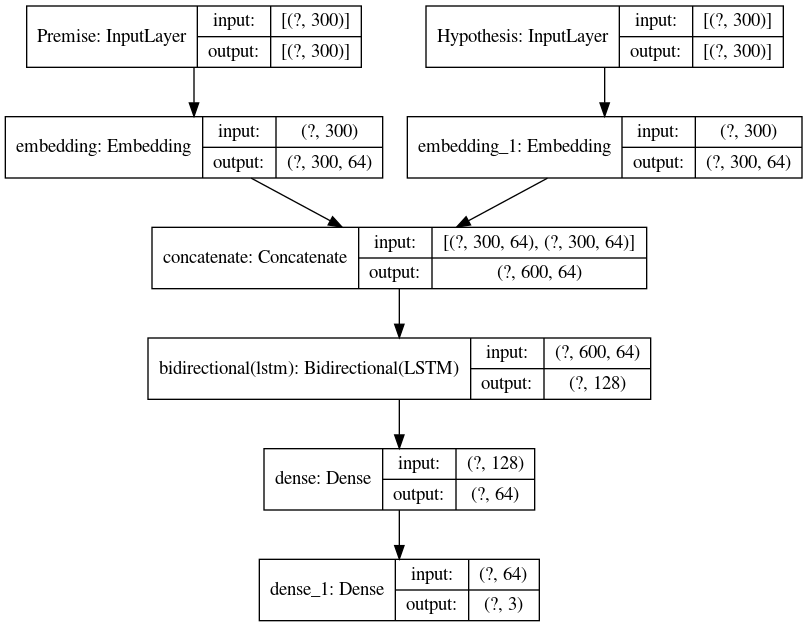

In [16]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [17]:
from __future__ import absolute_import, division, print_function, unicode_literals
tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [18]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [19]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [20]:
model.fit(dataset,
          epochs=10,
          verbose=1,
          callbacks=[cp_callback])

Epoch 1/10
    384/Unknown - 93s 243ms/step - loss: 1.0977 - accuracy: 0.3470
Epoch 00001: saving model to training_1/cp.ckpt
384/384 [==============================] - 93s 243ms/step - loss: 1.0977 - accuracy: 0.3470
Epoch 2/10
216/384 [===============>..............] - ETA: 39s - loss: 1.0983 - accuracy: 0.3399
Epoch 00002: saving model to training_1/cp.ckpt


KeyboardInterrupt: 

In [ ]:
model.save('saved_model/my_model') 